In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from scipy.signal import argrelextrema
import math
import numpy as np
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.legend_handler import HandlerBase
import matplotlib.pyplot as plt
import sys
import os,glob
import yaml
from scipy.special import gamma
from scipy.optimize import fsolve
from scipy.interpolate import interp1d  
import pandas as pd
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
from tqdm import tqdm 
from decimal import Decimal
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size']=13
plt.rcParams['text.usetex']=True
plt.rcParams['font.family']='stix'
plt.rcParams['figure.figsize']= (6.5,4)
plt.rcParams['figure.dpi']=150
plt.rcParams['axes.facecolor'] = 'white'

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {'width':1400,'scroll': True})

{'width': 1400, 'height': 768, 'scroll': True}

In [2]:
class VDS0():  

############################# INITIALIZATION #############################
    
    def __init__(self, h = 0.6932, Omega_m = 0.23995, Omega_b = 0.04626, Omega_rad = 9.23640e-5, p_crit = 4.755e-6,
                 rho_crit = 4.755e-6, T0 = 2.7255, kb = 8.617333262145e-5, m_p = 0.93827231, nu = 1.12,
                 Y_p = 0.75, n_e = 0.18820, x_e = 1.16371, sigmaT = 6.65246e-29, c = 3e5, Mpc2cm = 3.086e24, 
                 masses = np.array([1.5e-5,1e-4,1e-3,1e-2,1e-1,1.,10.,100.]), 
                 sigma_array = np.logspace(-10,-40,600)):
        
        self.h = h
        self.H0 = 100*h
        self.Omega_m = Omega_m
        self.Omega_b = Omega_b
        self.Omega_rad = Omega_rad
        self.Y_p = Y_p
        self.m_p = m_p
        self.nu = nu
        self.n_e = n_e
        self.x_e = x_e
        self.sigmaT = sigmaT
        self.rho_crit = 1.256*10**11*Omega_m
        self.rho_b = Omega_b*p_crit
#         self.T_0 = kb*T0*1e-9
        self.T_0 = 2.353e-13        
        self.Mpc2m = Mpc2cm*1e-2
        self.Rx_conerverionFactor = c*Mpc2cm
        
        self.masses = masses
        self.sigma_array = sigma_array
            
############################# SEMI-ANALYTIC FUNCTIONS #############################
    
    def N_0(self,n):
        return pow(2,(5.+n)/2.)*gamma(3.+n/2.)/(3.*np.sqrt(np.pi))

    def mhm2khm(self,Mhm):
        return np.pi/self.h*(((4.*np.pi*self.rho_crit)/(3*Mhm))**(1./3.))
        
    def Rx(self,z,sigma_0, m_x, n):
        return pow(z,2)*self.N_0(n)*self.Y_p*self.rho_b*self.Rx_conerverionFactor*(sigma_0/(m_x+self.m_p))*(pow(((self.T_0*(1+z))/(m_x))+((self.T_0*(1+z))/self.m_p),((1.+n)/2.)))

    def Rx_noZ(self,sigma_0, m_x, n):
        return self.N_0(n)*self.Y_p*self.rho_b*self.Rx_conerverionFactor*(sigma_0/(m_x+self.m_p))*(pow((self.T_0/m_x)+(self.T_0/self.m_p),((1.+n)/2.)))
    
    def Rx_kin(self,z,sigma_0,m_x,n):
        return (pow(z,2) * ((self.T_0*z**2)/(self.z_th(sigma_0,m_x,n)*m_x) + (self.T_0*z)/self.m_p)**((n+1.)/2.))*(self.N_0(n)*self.Y_p*self.rho_b*self.Rx_conerverionFactor*(sigma_0/(m_x+self.m_p)))

    def Rx_th(self,z,sigma_0, m_x, n):
        return pow(z,2)*self.N_0(n)*self.Y_p*self.rho_b*self.Rx_conerverionFactor*(sigma_0/(m_x+self.m_p))*(pow((self.T_0*z)/(m_x)+((self.T_0*z)/self.m_p),((1.+n)/2.)))
    
    def Rgamma(self,z):
        return pow(z,2)*self.n_e*self.x_e*self.sigmaT*self.Mpc2m
    
    def aH(self,z,sigma_0,m_x,n):
        return z*(self.H0*np.sqrt(self.Omega_rad))

    def z_th(self,sigma_0,m_x,n):
        return ((self.H0*np.sqrt(self.Omega_rad)*(m_x+self.m_p))/(self.Rx_noZ(sigma_0,m_x,n)*m_x))**(2./(n+3.))

    def z_kin(self,sigma_0,m_x,n):
        return fsolve(lambda z: z * ((self.T_0*z**2)/((1+self.z_th(sigma_0,m_x,n))*m_x) + (self.T_0*z)/self.m_p)**((n+1.)/2.) - (self.H0*np.sqrt(self.Omega_rad)/(self.N_0(n)*self.Y_p*self.rho_b*self.Rx_conerverionFactor))*(m_x+self.m_p)/sigma_0,self.z_th(sigma_0,m_x,n)/2.)    
    
    def z_gamma(self,sigma_0,m_x,n):
        return fsolve(lambda z: ((self.T_0*z**2)/(self.z_th(sigma_0,m_x,n)*m_x) + (self.T_0*self.z_th(sigma_0,m_x,n))/self.m_p)**((n+1.)/2.) - (self.n_e*self.x_e*self.sigmaT*self.Mpc2m/(self.N_0(n)*self.Y_p*self.rho_b*self.Rx_conerverionFactor))*(m_x+self.m_p)/sigma_0,self.z_th(sigma_0,m_x,n)/2.)    

    def sigma2k(self,sigma_0,m_x,n):
        return 2*(self.H0*np.sqrt(self.Omega_rad)*self.z_kin(sigma_0,m_x,n))*3.33e-6
    
    def sigma2k2(self,sigma_0,m_x,n):
        return 2*(self.H0*np.sqrt(self.Omega_rad)*self.z_gamma(sigma_0,m_x,n))*3.33e-6

    def sig(self,klimit,n,masses):
        sigma = []
        for i in range(len(masses)):
            sigma.append(self.sigma_array[np.argmin(np.abs(self.sigma2k(self.sigma_array,masses[i],n)-self.h*klimit))])
        return np.array(sigma)

    def sig2(self,klimit,n):
        sigma = []
        for i in range(len(self.masses)):
            sigma.append(self.sigma_array[np.argmin(np.abs(self.sigma2k2(self.sigma_array,self.masses[i],n)-self.h*klimit))])
        return np.array(sigma)
    
    def sigma_vs_mx(self,klimit,n):
        return hv.Curve((masses, self.sig(klimit,n)))
    
############################# INI GENERATION #############################

    def make_inis(self,ini_base_file='class/inis/dmeff_base.ini',base_inis_path='class/inis/',class_runner_path = 'class/',npow=0,
                  masses=np.array([1e-4,1e-3,1e-2,1e-1,1.,10.]),sigmas=np.logspace(-20,-30,100),output_path='pk_output',
                  sh_file='class/run_classes.sh'):
    
        fin =  open(ini_base_file, 'r')
        base_content = fin.read()
        fin.close()
        fout_sh = open(class_runner_path+'run_classes.sh', 'w')

        for m in masses:
            for sigma in sigmas:
                filename = 'n{}_m{}_s{}.ini'.format(npow,m,sigma)
                fout_sh.write('./class ' + 'inis/{}\n'.format(filename))
                fout = open(base_inis_path + filename, 'w')
                fout.write(base_content)
                fout.write('\n')
                npow_line = 'npow_dmeff = {}\n'.format(npow)
                fout.write(npow_line)
                m_line = 'm_dmeff = {}\n'.format(m)
                fout.write(m_line)
                sigma_line = 'sigma_dmeff = {}\n'.format(sigma)
                fout.write(sigma_line)
                if npow<0:
                    vel_line = 'Vrel_dmeff_rate = 30\n' #sets to DBK case.
                    fout.write(vel_line)
                root_line = 'root = {}/n{}_m{}_s{}_\n'.format(output_path,npow,m,sigma)
                fout.write(root_line)

        fout_sh.close()

############################# TK PLOTTING FUNCTIONS #############################
        
    def single_tk(self,npow=0,m=0.0001,plotPeaks=False,pltType='none',
                  index=0,sigmas=np.logspace(-20,-30,100),lw=2.5,label='',
                  c='k',ls='-',alpha=1):

        data0 = np.loadtxt('class/pk_output/lcdm_z1_pk.dat')
        ks = data0[:,0]
        pk0 = data0[:,1]

        for i,sigma in enumerate(sigmas):
            # Index of interest
            if i!=index:
                continue
            print(sigma)
            
            # pk data from class for given mass, sigma, power
            filename = 'class/pk_output/n{}_m{}_s{}_z1_pk.dat'.format(npow,m,sigma)   
            print(filename)
            data = np.loadtxt(filename)
            pk = data[:,1]
            
            ax.plot(ks,pk[:255]/pk0[:255],linewidth=lw,linestyle=ls,color=c,label=label,alpha=alpha)        

        return (pk[:255])/pk0[:255],ks,sigma
    
    def all_sigmas(self,npow=0,m=0.0001,sigmas=np.logspace(-20,-30,100),
               z='z1',colorbar=False,pk_root='class/pk_output/',
               filename=None,label='',lw=0.3,lowlim=0,uplim=100,c='r'):
        
        cm = LinearSegmentedColormap.from_list("mycmap", ['#D81B60','tan','#63acbe'])
        cm2 = LinearSegmentedColormap.from_list("mycmap", ['#63acbe','tan','#D81B60'])
        
        data0 = np.loadtxt('class/pk_output/lcdm_z1_pk.dat')
        ks = data0[:,0]
        pk0 = data0[:,1]

        for i,sigma in enumerate(sigmas):
            if i>=uplim or i<lowlim or i==len(sigmas)-1 or i%5!=0:
                continue
                
            # colors/labels for peak plot
            lbl = "$\sigma_0=$"+str('{:.1e}'.format(float(sigma)))+r"$\textrm{ cm}^2$"
            c=cm(int(i*4.))

            try:                                    
                # pk data from class for given mass, sigma, power
                filename = 'class/pk_output/n{}_m{}_s{}_z1_pk.dat'.format(npow,m,sigma)            
                data = np.loadtxt(filename)
                pk = data[:,1]
                ax.semilogx(ks,pk/pk0,linewidth=lw,linestyle='-',color=c,alpha=1.) 
                sc = plt.scatter(ks,(pk)/pk0, c=np.logspace(-20,-30,246), cmap=cm2,s=0.001,alpha=0.7)
            except: continue
           
    def all_masses(self,npow=0,masses=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1],
                   sigma=1e-20,z='z1',colorbar=False,pk_root='class/pk_output/',
                   filename=None,label='',lw=0.3):
        
        cm = LinearSegmentedColormap.from_list("mycmap", ['#63acbe','tan','#D81B60'])
    
        data0 = np.loadtxt('class/pk_output/lcdm_z1_pk.dat')
        ks = data0[:,0]
        pk0 = data0[:,1]

        for i,m in enumerate(masses):
            lbl = "$\mass=$"+str('{:.1e}'.format(float(m)))+r"$\textrm{ GeV}$"
            c=cm(int(i*35.))

            # pk data from class for given mass, sigma, power
            filename = 'class/pk_output/n{}_m{}_s{}_z1_pk.dat'.format(npow,m,sigma)            
            data = np.loadtxt(filename)
            pk = data[:,1]

            ax.semilogx(ks,pk/pk0,linewidth=lw,linestyle='-',color=c,label=lbl,alpha=1.) 
            sc = plt.scatter(ks,(pk)/pk0, c=np.logspace(-20,-30,246), cmap=cm,s=0.001,alpha=0.7)
                
        if colorbar:
            tick_locs = [1e-30,1e-20]
            tick_labels = ["$m = 10^{-5}$ GeV","$m = 10$ GeV"]
            cb = plt.colorbar(sc, orientation="vertical")
            cb.locator = matplotlib.ticker.FixedLocator(tick_locs)
            cb.formatter = matplotlib.ticker.FixedFormatter(tick_labels)
            cb.update_ticks()
            cb.ax.tick_params(labelsize=33,length=15,width=3,color='w')
            cb.ax.locator_params(nbins=2)
            
    def transfer(self,k,mwdm):
        lambda_fs = (0.049*(mwdm**(-1.11))*((self.Omega_m/0.25)**(0.11))*((self.h/0.7)**1.22))
        alpha = lambda_fs
        transfer = (1+(alpha*k)**(2*self.nu))**(-5./self.nu)
        return transfer

vds0 = VDS0()

# Bounds on velocity-dependent dark matter-proton scattering from Milky Way satellite abundance <br><br>
<font color=crimson>Karime Maamari</font>

## Background

1. The Standard Model of Cosmology and cold dark matter

2. The Missing Satellites Problem and interacting dark matter

## Approaches

1. <font color=teal>Analytic</font> (Boddy & Gluscevic 2018, Nadler et al. 2020a)

2. <font color=crimson>Numerical</font> (Fitting transfer functions)

## Background

The standard $\Lambda$CDM model of cosmology assumes dark matter to be a cold, collisionless particle<br><br>
<img src="star-DM-loop130.gif" width="375" align="center">
[$\tiny(\text{Courtesy A. Wetzel, 2016})$](https://carnegiescience.edu/news/reconciling-dwarf-galaxies-dark-matter)

The Missing Satellites Problem — simulated satellite galaxies significantly outnumber observations

&nbsp; &nbsp; &nbsp; &nbsp;Interacting dark matter wipes out excess satellites, matching observations

<img src="satellites.png" width="1100" align="center"> 
[$\tiny(\text{Courtesy C. Boehm, 2014})$](https://academic.oup.com/mnrasl/article/445/1/L31/1130905)

Constraints allow:
1. Theorists to better construct models
2. Expiermentalists to better identify potential candidates for experimentation<br><br>
<img src="xkcd.png" width="1050" align="center"> 
[$\tiny(\text{Courtesy XKCD, 2018})$](https://xkcd.com/2035/)

## Theoretical formalism

**Decoupling:** The dissociation of one or more bodies from each other, the moment at which interactions between particles halt

Compton scattering rate = Hubble rate $\rightarrow$ **Photon decoupling** $\rightarrow$ "Let there be light"

Momentum transfer rate = Hubble rate $\rightarrow$ **Kinetic decoupling**

&nbsp; &nbsp; &nbsp; &nbsp;$R_{\chi}(z,\sigma_0,...)=aH(z) \rightarrow z_{crit}$

Size of horizon at $z_{crit}$ = $\lambda_{crit}$ = $2\pi/k_{crit}$

&nbsp; &nbsp; &nbsp; &nbsp;Where $k_{crit}$ is the scale at which power sufficiently suppressed

Assuming a sphere of radius $\frac{\lambda_{crit}}{2}$ permits the translation of $k_{crit}$ to $M_{crit}$

&nbsp; &nbsp; &nbsp; &nbsp;$\frac{4\pi}{3}\overline{\rho}\left(\frac{\lambda_{crit}}{2}\right)^3 =\frac{4\pi}{3}\overline{\rho}\left(\frac{\pi}{k_{crit}}\right)^3 = M_{crit}$

$\small M_{crit}(k(z(\sigma_0,...)))$

# <font color=teal>Analytic approach: </font> 
&nbsp; &nbsp; &nbsp; &nbsp;$\small M_{crit}(k(z(\sigma_0,...)))$

Start from minimum halo mass of Milky Way satellite galaxies (Nadler et al. 2020a): <br>
&nbsp; &nbsp; &nbsp; &nbsp;$M_{crit}=3.2\times 10^{8}M_{\odot}$ 

Given $M$, solve for $k$: <br>
&nbsp; &nbsp; &nbsp; &nbsp;$M_{crit}=\frac{4\pi}{3}\overline{\rho}\left(\frac{\pi}{k_{crit}}\right)^3$

In [3]:
Mcrit=3.2e8
klim=np.pi/vds0.h*(((4.*np.pi*vds0.rho_crit)/(3*Mcrit))**(1./3.))
print('k =',klim)

k = 33.23846762538796


Assert that the critical scale be a full oscillation of the cosmological horizon:<br>
&nbsp; &nbsp; &nbsp; &nbsp;$k_{crit}=2aH=2H_0\sqrt{\Omega_{rad}}z(\sigma_0,m_{\chi},n)$

In [4]:
# DM masses
masses = np.array([1e-4,1e-3,1e-2,1e-1,1.,10.])

# Velocity-dependencies
n=np.array([0,2,4,6])

# kcrit
klim=33.2

# Interate through and pull out sigma0 corresponding to kcrit
for i in range(len(n)):
    sigma = []
    for j in range(len(masses)):
        sigma.append('%.2E' % Decimal(vds0.sigma_array[np.argmin(np.abs(vds0.sigma2k(vds0.sigma_array,masses[j],n[i])-vds0.h*klim))]))
    print("For n =",n[i],":",np.array(sigma))

For n = 0 : ['3.31E-29' '5.88E-29' '1.05E-28' '1.86E-28' '5.26E-28' '3.74E-27']
For n = 2 : ['1.49E-27' '1.88E-26' '2.37E-25' '3.00E-24' '3.80E-23' '4.28E-22']
For n = 4 : ['2.11E-26' '2.68E-24' '3.03E-22' '3.05E-20' '1.94E-18' '3.88E-17']
For n = 6 : ['2.12E-25' '2.40E-22' '2.73E-19' '2.46E-16' '7.85E-14' '2.50E-12']


# <font color=crimson>Numerical approach</font>

Start from minimum halo mass of Milky Way satellite galaxies (Nadler et al. 2020a): <br>
&nbsp; &nbsp; &nbsp; &nbsp;$M_{crit}=3.2\times 10^{8}M_{\odot}$ 

Given $M$, solve for $k$: <br>
&nbsp; &nbsp; &nbsp; &nbsp;$M_{crit}=\frac{4\pi}{3}\overline{\rho}\left(\frac{\pi}{k_{crit}}\right)^3$

In [5]:
Mcrit=3.2e8
klim=np.pi/vds0.h*(((4.*np.pi*vds0.rho_crit)/(3*Mcrit))**(1./3.))
print('k =',klim)

k = 33.23846762538796


Construct the WDM transfer function associated with a critical scale of $k_{crit}=33.2$ and fit IDM transfer functions accordingly

In [6]:
blue1='#2F5058'
blue2='#5B92A0'
blue3='#75C6DA'
red1='#ED578D'
red2='#D81B60'
red3='#7E1038'
ls='-'

ks2 = np.logspace(-5,4,1000)

5.455594781168515e-16
class/pk_output/n4_m1_s5.455594781168515e-16_z1_pk.dat


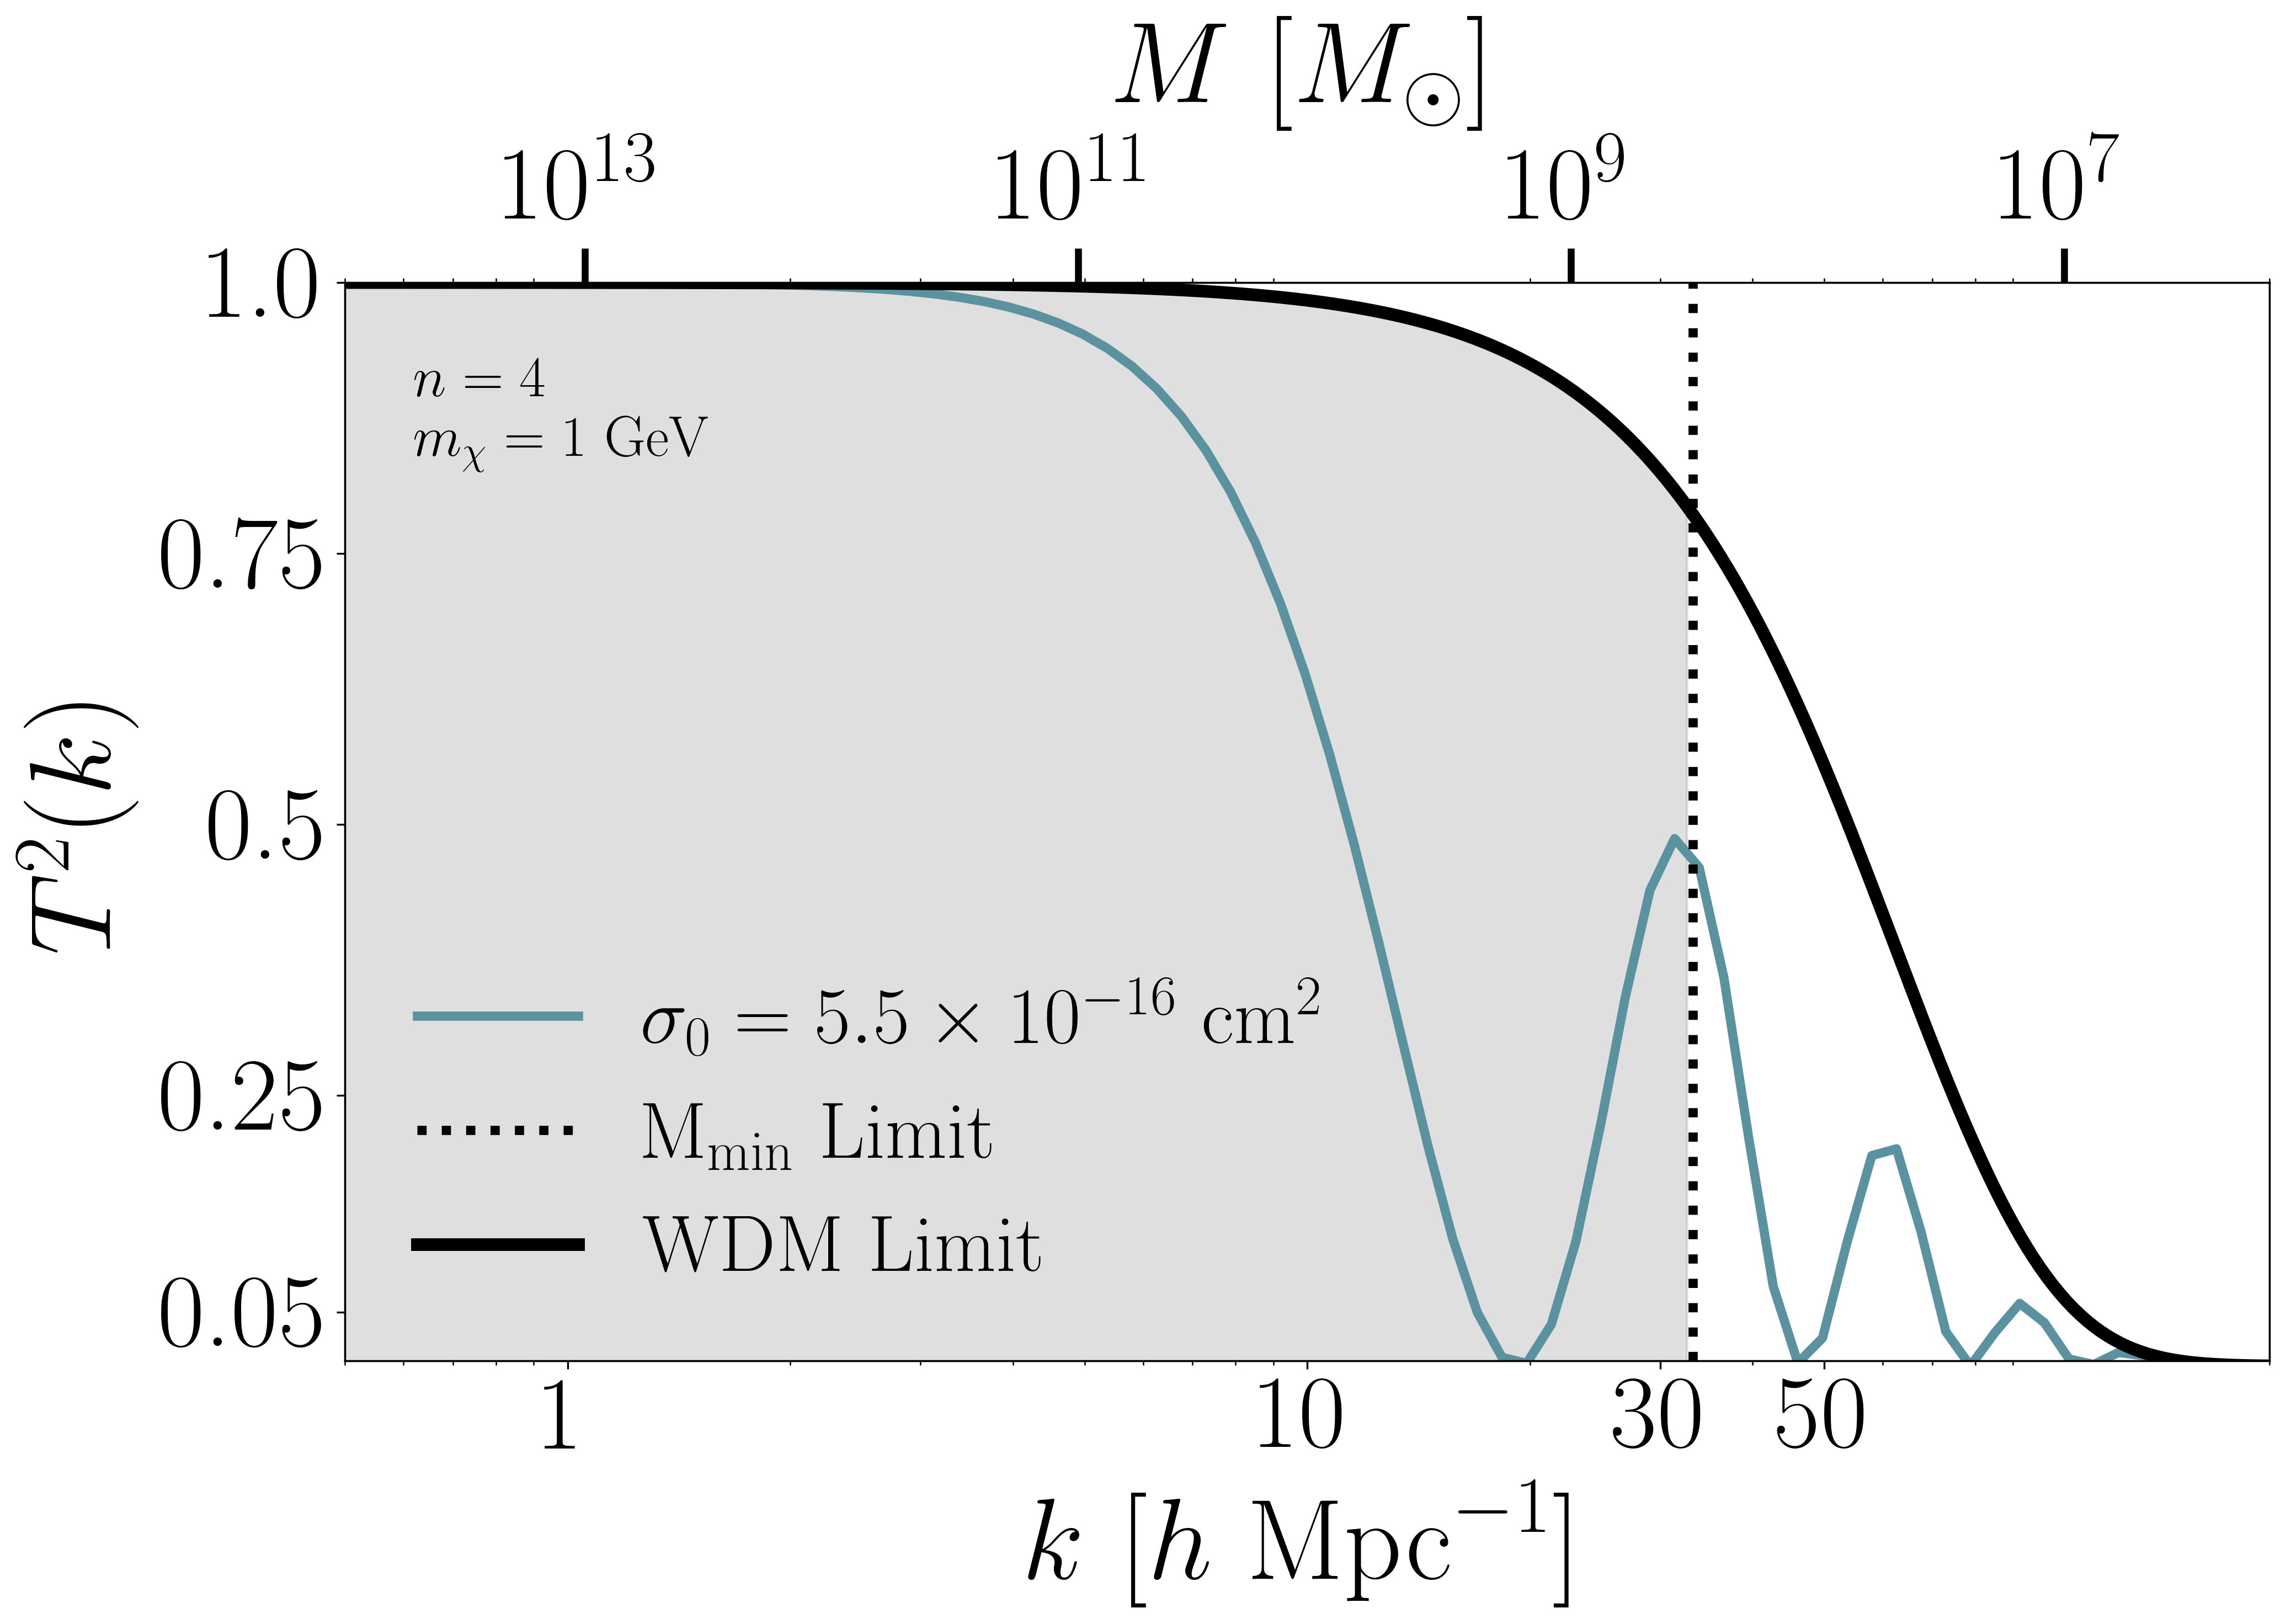

In [7]:
fig = plt.figure(figsize=(14,10))    
ax = fig.add_subplot(111)
ax2 = ax.twiny()

################################################# IDM Limits #########################################################
# tk_idm_c,ks,sigma0 = vds0.single_tk(npow=4,m=1,sigmas=np.logspace(-15,-20,20),index=7,ls='-',c='#5B92A0',label=r'$\sigma_0= 1.4\times 10^{-17}$ cm$^2$',lw=4)
tk_idm_c,ks,sigma0 = vds0.single_tk(npow=4,m=1,sigmas=np.logspace(-15,-20,20),index=1,ls='-',c='#5B92A0',label=r'$\sigma_0= 5.5\times 10^{-16}$ cm$^2$',lw=4)

############################################### WDM/Mmin Limits #########################################################
ax.axvline(klim,c='k',ls=':',lw=4,label=r'M$_{\rm{min}}$ Limit')
ax.semilogx(ks2,vds0.transfer(ks2,6.5)**2,linestyle='-',label='WDM Limit',c='k',lw=5.5)
ax.fill_between(np.logspace(-5,4,1000), -10, vds0.transfer(ks2,6.5)**2,where=np.logspace(-5,4,1000)<klim,color='grey',alpha=0.25)

################################################# PLOT OPTIONS #####################################################
ax.set_xscale('log')
ax.set_xlim(0.5,200)
ax.set_ylim(0.005,1.)
ax.set_xlabel(r'$k$ [$h\ \rm{Mpc}^{-1}$]',fontsize=50,labelpad=5)
ax.set_ylabel(r'$T^2(k)$',fontsize=50,labelpad=10)
ax.set_xticks([1,10,30,50])
ax.set_xticklabels(["1","10","30","50"],fontsize=45)
ax.set_yticks([0.05,0.25,0.5,0.75,1.0])
ax.set_yticklabels([0.05,0.25,0.5,0.75,1.0],fontsize=45)
ax.legend(fontsize=35,framealpha=0,loc='lower left')
ax2.set_xscale('log')
ax2.set_xlim(0.5,200)
ax2.set_xticks([vds0.mhm2khm(10**13),vds0.mhm2khm(10**11),vds0.mhm2khm(10**9),vds0.mhm2khm(10**7)])
ax2.set_xticklabels([r'10$^{13}$',r'10$^{11}$',r'10$^{9}$',r'10$^{7}$'],fontsize=45)
ax2.set_xlabel(r'$M$ [$M_{\rm{\odot}}$]',fontsize=50,labelpad=20)
ax.text(0.62,0.84,"$n=4$\n$m_{\chi}=1$ GeV",fontsize=25)
ax2.tick_params(length=15,width=3)

plt.tight_layout()    

# Limits

<img src="plots/limits/limits_n0.png" width="1000">

<img src="plots/limits/limits_n2.png" width="1000">

<img src="plots/limits/limits_n4.png" width="1000">

<img src="plots/limits/limits_n6.png" width="1000">

Analytic approach improves upon CMB limits by:<br>
&nbsp; &nbsp; &nbsp; &nbsp;2 orders of magnitude for n=0<br>
&nbsp; &nbsp; &nbsp; &nbsp;5 orders of magnitude for n=2<br>
&nbsp; &nbsp; &nbsp; &nbsp;7 orders of magnitude for n=4

Numerical approach improves upon CMB limits by:<br>
&nbsp; &nbsp; &nbsp; &nbsp;2 orders of magnitude for n=0<br>
&nbsp; &nbsp; &nbsp; &nbsp;4 orders of magnitude for n=2<br>
&nbsp; &nbsp; &nbsp; &nbsp;5 orders of magnitude for n=4

<img src="limits.png" width="1000">

<img src="plots/exclusions/tk_numerical.png" width="1000">

# Summary

**Objective:** Constrain alternative models of DM which assume DM-proton interactions

**<font color=teal>Analytic approach: </font>**  Kinetic decoupling $\rightarrow$ Point of last scattering $\rightarrow$ Critical scale of suppression $\rightarrow$ Critical (minimum halo) mass $\rightarrow$ Scatering cross-section<br>

**<font color=crimson>Numerical approach: </font>**  Critical mass $\rightarrow$ Critical scale $\rightarrow$ WDM transfer function $\rightarrow$ IDM transfer function $\rightarrow$ Scattering cross-section

**Results:** Several orders of magnitude improvement upon prior limits

# Takeaway
New observations of the minimum halo mass of Milky Way satellite galaxies allow for the imposition of stringent constraints on the scattering cross-section of velocity dependent DM-proton interactions